# Training 2 prefinal layers

In ResNet18, the forward pass is:
```
def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
```
We can train only the 2 prefinal layers (layer3, layer4) by loading the pre-trained model, then setting the `requires_grad` attribute of the parameters outside these two layers to `False`.

In [1]:
def freeze(layer):
    for param in layer.parameters():
        param.requires_grad = False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.models as models
from torchvision import transforms

from PIL import Image
import numpy as np
import pandas as pd
import os

class FlowerDataset(Dataset):
    def __init__(self, image_dir, image_paths, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = np.load(label_file)
        self.image_label_pairs = self._load_paths(image_paths)
        self.transform = transform
        
    def train_val_test_split(self, train_ratio, val_ratio):
        dataset_length = len(self.image_label_pairs)
        train_length = int(train_ratio * dataset_length)
        val_length = int(val_ratio * dataset_length)
        test_length = len(self) - train_length - val_length
        splits = [train_length, val_length, test_length]
        return random_split(self, splits)
        
    def _load_paths(self, file_path):
        """
        params:  file_path, a path pointing to where the image paths are stored.
        returns: dictionary with keys 'full_image_path', and values 'label'
        """
        split_set = {}
        with open(file_path) as f:
            lines = f.readlines()
            num_lines = len(lines)
            assert(num_lines == len(self.labels))
            for line_num in range(num_lines):
                full_image_path = os.path.join(self.image_dir, lines[line_num].strip('\n'))
                split_set[full_image_path] = self.labels[line_num]
        return pd.DataFrame.from_dict(split_set, orient='index')
        
    def _load_image(self, image_path):
        img = Image.open(image_path)
        img.load()
        img = np.array(img)
        if len(img.shape) == 2:
            img = np.expand_dims(img, 2)
            img = np.repeat(img, 3, 2)
        return Image.fromarray(img)
        
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        # apply transforms
        image_path = self.image_label_pairs.index[idx]
        image = self._load_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return {'image': image,
                'label': label}
    
transform = transforms.Compose([transforms.CenterCrop(200), transforms.ToTensor()])
dataset = FlowerDataset('data', 'image_paths.txt', 'labels.npy', transform=transform)
train_set, val_set, test_set = dataset.train_val_test_split(0.7, 0.1)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=4)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    for idx, batch in enumerate(train_loader):
        data, target = batch['image'].to(device), batch['label'].long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = CE(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print('Epoch: {}, Samples: {}/{}, Loss: {}'.format(epoch, idx*batch_size,
                                                           len(train_loader)*batch_size,
                                                           loss.item()))
    train_loss = torch.mean(torch.tensor(train_losses))
    print('\nEpoch: {}'.format(epoch))
    print('Training set: Average loss: {:.4f}'.format(train_loss))
    
    return train_loss

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            data, target = batch['image'].to(device), batch['label'].long().to(device)
            output = model(data)
            
            # compute the batch loss
            batch_loss = CE(output, target).item()
            val_loss += batch_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of batches of batch size 32
    # get the average validation over all bins
    val_loss /= len(val_loader)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return val_loss

DATA_DIRECTORY = 'data/'
use_cuda = 1
batch_size = 32
num_epochs = 50
learning_rate = 1e-3

device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)

# freeze all layers before layer3
freeze(model.conv1)
freeze(model.bn1)
freeze(model.layer1)
freeze(model.layer2)
model.fc = nn.Linear(512, 102)

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
CE = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    val_loss = validate(model, device, val_loader)

    if (len(val_losses) > 0) and (val_loss < min(val_losses)):
        torch.save(model.state_dict(), "best_model_c.pt")
        print("Saving model (epoch {}) with lowest validation loss: {}"
              .format(epoch, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Training and validation complete.")

Epoch: 1, Samples: 0/5760, Loss: 4.717750072479248
Epoch: 1, Samples: 32/5760, Loss: 4.6913251876831055
Epoch: 1, Samples: 64/5760, Loss: 4.779818058013916
Epoch: 1, Samples: 96/5760, Loss: 4.927428245544434
Epoch: 1, Samples: 128/5760, Loss: 4.704293251037598
Epoch: 1, Samples: 160/5760, Loss: 4.946402072906494
Epoch: 1, Samples: 192/5760, Loss: 4.80712366104126
Epoch: 1, Samples: 224/5760, Loss: 4.796818256378174
Epoch: 1, Samples: 256/5760, Loss: 4.815865993499756
Epoch: 1, Samples: 288/5760, Loss: 4.6611433029174805
Epoch: 1, Samples: 320/5760, Loss: 4.5955400466918945
Epoch: 1, Samples: 352/5760, Loss: 4.680673599243164
Epoch: 1, Samples: 384/5760, Loss: 4.770688533782959
Epoch: 1, Samples: 416/5760, Loss: 4.472278594970703
Epoch: 1, Samples: 448/5760, Loss: 4.494872093200684
Epoch: 1, Samples: 480/5760, Loss: 4.540658950805664
Epoch: 1, Samples: 512/5760, Loss: 4.629475116729736
Epoch: 1, Samples: 544/5760, Loss: 4.522205829620361
Epoch: 1, Samples: 576/5760, Loss: 4.327990531921

Epoch: 1, Samples: 4864/5760, Loss: 3.1376218795776367
Epoch: 1, Samples: 4896/5760, Loss: 3.321040391921997
Epoch: 1, Samples: 4928/5760, Loss: 2.7606546878814697
Epoch: 1, Samples: 4960/5760, Loss: 3.1814992427825928
Epoch: 1, Samples: 4992/5760, Loss: 2.851891040802002
Epoch: 1, Samples: 5024/5760, Loss: 2.5713911056518555
Epoch: 1, Samples: 5056/5760, Loss: 3.266106367111206
Epoch: 1, Samples: 5088/5760, Loss: 2.7504682540893555
Epoch: 1, Samples: 5120/5760, Loss: 2.9286606311798096
Epoch: 1, Samples: 5152/5760, Loss: 2.537576913833618
Epoch: 1, Samples: 5184/5760, Loss: 2.8131489753723145
Epoch: 1, Samples: 5216/5760, Loss: 2.4810752868652344
Epoch: 1, Samples: 5248/5760, Loss: 2.913292407989502
Epoch: 1, Samples: 5280/5760, Loss: 2.726879119873047
Epoch: 1, Samples: 5312/5760, Loss: 2.8416314125061035
Epoch: 1, Samples: 5344/5760, Loss: 2.788360834121704
Epoch: 1, Samples: 5376/5760, Loss: 2.637686252593994
Epoch: 1, Samples: 5408/5760, Loss: 2.7634057998657227
Epoch: 1, Samples:

Epoch: 2, Samples: 3872/5760, Loss: 1.6333404779434204
Epoch: 2, Samples: 3904/5760, Loss: 1.8073368072509766
Epoch: 2, Samples: 3936/5760, Loss: 1.5882678031921387
Epoch: 2, Samples: 3968/5760, Loss: 1.843001365661621
Epoch: 2, Samples: 4000/5760, Loss: 1.834728717803955
Epoch: 2, Samples: 4032/5760, Loss: 1.419399380683899
Epoch: 2, Samples: 4064/5760, Loss: 1.4353458881378174
Epoch: 2, Samples: 4096/5760, Loss: 1.4912391901016235
Epoch: 2, Samples: 4128/5760, Loss: 1.859710693359375
Epoch: 2, Samples: 4160/5760, Loss: 1.3978596925735474
Epoch: 2, Samples: 4192/5760, Loss: 1.4487136602401733
Epoch: 2, Samples: 4224/5760, Loss: 1.9073240756988525
Epoch: 2, Samples: 4256/5760, Loss: 1.4318039417266846
Epoch: 2, Samples: 4288/5760, Loss: 1.8428969383239746
Epoch: 2, Samples: 4320/5760, Loss: 2.111941337585449
Epoch: 2, Samples: 4352/5760, Loss: 1.6386313438415527
Epoch: 2, Samples: 4384/5760, Loss: 2.131545066833496
Epoch: 2, Samples: 4416/5760, Loss: 1.5789294242858887
Epoch: 2, Sample

Epoch: 3, Samples: 2848/5760, Loss: 1.389174461364746
Epoch: 3, Samples: 2880/5760, Loss: 1.3209861516952515
Epoch: 3, Samples: 2912/5760, Loss: 1.0813963413238525
Epoch: 3, Samples: 2944/5760, Loss: 1.0065653324127197
Epoch: 3, Samples: 2976/5760, Loss: 0.916588544845581
Epoch: 3, Samples: 3008/5760, Loss: 1.0686306953430176
Epoch: 3, Samples: 3040/5760, Loss: 1.2468087673187256
Epoch: 3, Samples: 3072/5760, Loss: 1.2468163967132568
Epoch: 3, Samples: 3104/5760, Loss: 1.0820444822311401
Epoch: 3, Samples: 3136/5760, Loss: 0.9128859043121338
Epoch: 3, Samples: 3168/5760, Loss: 0.9123457670211792
Epoch: 3, Samples: 3200/5760, Loss: 0.9715058207511902
Epoch: 3, Samples: 3232/5760, Loss: 1.247359275817871
Epoch: 3, Samples: 3264/5760, Loss: 0.9941120743751526
Epoch: 3, Samples: 3296/5760, Loss: 1.5476223230361938
Epoch: 3, Samples: 3328/5760, Loss: 0.8413565754890442
Epoch: 3, Samples: 3360/5760, Loss: 1.2352427244186401
Epoch: 3, Samples: 3392/5760, Loss: 1.2584253549575806
Epoch: 3, Sam

Epoch: 4, Samples: 1792/5760, Loss: 1.061971664428711
Epoch: 4, Samples: 1824/5760, Loss: 0.8917094469070435
Epoch: 4, Samples: 1856/5760, Loss: 0.6979020237922668
Epoch: 4, Samples: 1888/5760, Loss: 0.8591164350509644
Epoch: 4, Samples: 1920/5760, Loss: 0.7758579254150391
Epoch: 4, Samples: 1952/5760, Loss: 0.7583854794502258
Epoch: 4, Samples: 1984/5760, Loss: 0.6241658329963684
Epoch: 4, Samples: 2016/5760, Loss: 0.7651427984237671
Epoch: 4, Samples: 2048/5760, Loss: 0.9982950687408447
Epoch: 4, Samples: 2080/5760, Loss: 0.6870539784431458
Epoch: 4, Samples: 2112/5760, Loss: 0.8380646109580994
Epoch: 4, Samples: 2144/5760, Loss: 0.8127431869506836
Epoch: 4, Samples: 2176/5760, Loss: 0.6558507084846497
Epoch: 4, Samples: 2208/5760, Loss: 0.6821129322052002
Epoch: 4, Samples: 2240/5760, Loss: 0.7763908505439758
Epoch: 4, Samples: 2272/5760, Loss: 0.8784489631652832
Epoch: 4, Samples: 2304/5760, Loss: 0.8791190385818481
Epoch: 4, Samples: 2336/5760, Loss: 0.6374443769454956
Epoch: 4, S

Epoch: 5, Samples: 736/5760, Loss: 0.41472959518432617
Epoch: 5, Samples: 768/5760, Loss: 0.5530381202697754
Epoch: 5, Samples: 800/5760, Loss: 0.7262091636657715
Epoch: 5, Samples: 832/5760, Loss: 0.5988219976425171
Epoch: 5, Samples: 864/5760, Loss: 0.6585223078727722
Epoch: 5, Samples: 896/5760, Loss: 0.5941503047943115
Epoch: 5, Samples: 928/5760, Loss: 0.7722218036651611
Epoch: 5, Samples: 960/5760, Loss: 0.5985637903213501
Epoch: 5, Samples: 992/5760, Loss: 0.5016716718673706
Epoch: 5, Samples: 1024/5760, Loss: 0.5642602443695068
Epoch: 5, Samples: 1056/5760, Loss: 0.8711889982223511
Epoch: 5, Samples: 1088/5760, Loss: 0.4953811764717102
Epoch: 5, Samples: 1120/5760, Loss: 0.7216495275497437
Epoch: 5, Samples: 1152/5760, Loss: 0.4387741684913635
Epoch: 5, Samples: 1184/5760, Loss: 0.5326858758926392
Epoch: 5, Samples: 1216/5760, Loss: 0.5029650926589966
Epoch: 5, Samples: 1248/5760, Loss: 0.6658204793930054
Epoch: 5, Samples: 1280/5760, Loss: 0.28247812390327454
Epoch: 5, Samples

Epoch: 5, Samples: 5536/5760, Loss: 0.4946536421775818
Epoch: 5, Samples: 5568/5760, Loss: 0.5761688947677612
Epoch: 5, Samples: 5600/5760, Loss: 0.6311002969741821
Epoch: 5, Samples: 5632/5760, Loss: 0.5873763561248779
Epoch: 5, Samples: 5664/5760, Loss: 0.4904439449310303
Epoch: 5, Samples: 5696/5760, Loss: 0.6014081239700317
Epoch: 5, Samples: 5728/5760, Loss: 2.332237720489502

Epoch: 5
Training set: Average loss: 0.5651
Validation set: Average loss: 0.6562, Accuracy: 703/818 (86%)
Saving model (epoch 5) with lowest validation loss: 0.6561657431033942
Epoch: 6, Samples: 0/5760, Loss: 0.5845206379890442
Epoch: 6, Samples: 32/5760, Loss: 0.5330395698547363
Epoch: 6, Samples: 64/5760, Loss: 0.3673168420791626
Epoch: 6, Samples: 96/5760, Loss: 0.4101771116256714
Epoch: 6, Samples: 128/5760, Loss: 0.3635111451148987
Epoch: 6, Samples: 160/5760, Loss: 0.47895562648773193
Epoch: 6, Samples: 192/5760, Loss: 0.3407299816608429
Epoch: 6, Samples: 224/5760, Loss: 0.6375648379325867
Epoch: 6, 

Epoch: 6, Samples: 4448/5760, Loss: 0.6412831544876099
Epoch: 6, Samples: 4480/5760, Loss: 0.32380402088165283
Epoch: 6, Samples: 4512/5760, Loss: 0.3831734359264374
Epoch: 6, Samples: 4544/5760, Loss: 0.5336311459541321
Epoch: 6, Samples: 4576/5760, Loss: 0.3951811194419861
Epoch: 6, Samples: 4608/5760, Loss: 0.4996044933795929
Epoch: 6, Samples: 4640/5760, Loss: 0.36981940269470215
Epoch: 6, Samples: 4672/5760, Loss: 0.3192439377307892
Epoch: 6, Samples: 4704/5760, Loss: 0.3796100914478302
Epoch: 6, Samples: 4736/5760, Loss: 0.2914509177207947
Epoch: 6, Samples: 4768/5760, Loss: 0.3975112736225128
Epoch: 6, Samples: 4800/5760, Loss: 0.48599204421043396
Epoch: 6, Samples: 4832/5760, Loss: 0.20128899812698364
Epoch: 6, Samples: 4864/5760, Loss: 0.4817490875720978
Epoch: 6, Samples: 4896/5760, Loss: 0.5158380270004272
Epoch: 6, Samples: 4928/5760, Loss: 0.4409309923648834
Epoch: 6, Samples: 4960/5760, Loss: 0.4734492897987366
Epoch: 6, Samples: 4992/5760, Loss: 0.3736436367034912
Epoch:

Epoch: 7, Samples: 3360/5760, Loss: 0.18171849846839905
Epoch: 7, Samples: 3392/5760, Loss: 0.30656567215919495
Epoch: 7, Samples: 3424/5760, Loss: 0.29848170280456543
Epoch: 7, Samples: 3456/5760, Loss: 0.2893270254135132
Epoch: 7, Samples: 3488/5760, Loss: 0.48345106840133667
Epoch: 7, Samples: 3520/5760, Loss: 0.41430243849754333
Epoch: 7, Samples: 3552/5760, Loss: 0.37402963638305664
Epoch: 7, Samples: 3584/5760, Loss: 0.22263090312480927
Epoch: 7, Samples: 3616/5760, Loss: 0.2736845910549164
Epoch: 7, Samples: 3648/5760, Loss: 0.2219909429550171
Epoch: 7, Samples: 3680/5760, Loss: 0.27394112944602966
Epoch: 7, Samples: 3712/5760, Loss: 0.3282443881034851
Epoch: 7, Samples: 3744/5760, Loss: 0.29712024331092834
Epoch: 7, Samples: 3776/5760, Loss: 0.37326493859291077
Epoch: 7, Samples: 3808/5760, Loss: 0.2254086136817932
Epoch: 7, Samples: 3840/5760, Loss: 0.35395580530166626
Epoch: 7, Samples: 3872/5760, Loss: 0.3357926309108734
Epoch: 7, Samples: 3904/5760, Loss: 0.2234481722116470

Epoch: 8, Samples: 2240/5760, Loss: 0.16730955243110657
Epoch: 8, Samples: 2272/5760, Loss: 0.26540911197662354
Epoch: 8, Samples: 2304/5760, Loss: 0.18198974430561066
Epoch: 8, Samples: 2336/5760, Loss: 0.32649099826812744
Epoch: 8, Samples: 2368/5760, Loss: 0.1438852846622467
Epoch: 8, Samples: 2400/5760, Loss: 0.21786776185035706
Epoch: 8, Samples: 2432/5760, Loss: 0.2323424369096756
Epoch: 8, Samples: 2464/5760, Loss: 0.2971328794956207
Epoch: 8, Samples: 2496/5760, Loss: 0.19237932562828064
Epoch: 8, Samples: 2528/5760, Loss: 0.15053094923496246
Epoch: 8, Samples: 2560/5760, Loss: 0.1734405905008316
Epoch: 8, Samples: 2592/5760, Loss: 0.2283155620098114
Epoch: 8, Samples: 2624/5760, Loss: 0.26790234446525574
Epoch: 8, Samples: 2656/5760, Loss: 0.13663923740386963
Epoch: 8, Samples: 2688/5760, Loss: 0.18067236244678497
Epoch: 8, Samples: 2720/5760, Loss: 0.265108585357666
Epoch: 8, Samples: 2752/5760, Loss: 0.30478793382644653
Epoch: 8, Samples: 2784/5760, Loss: 0.16807109117507935

Epoch: 9, Samples: 1120/5760, Loss: 0.2344968616962433
Epoch: 9, Samples: 1152/5760, Loss: 0.15280786156654358
Epoch: 9, Samples: 1184/5760, Loss: 0.12195378541946411
Epoch: 9, Samples: 1216/5760, Loss: 0.20245203375816345
Epoch: 9, Samples: 1248/5760, Loss: 0.15170283615589142
Epoch: 9, Samples: 1280/5760, Loss: 0.1301306039094925
Epoch: 9, Samples: 1312/5760, Loss: 0.2870613634586334
Epoch: 9, Samples: 1344/5760, Loss: 0.2135399430990219
Epoch: 9, Samples: 1376/5760, Loss: 0.18737336993217468
Epoch: 9, Samples: 1408/5760, Loss: 0.20902422070503235
Epoch: 9, Samples: 1440/5760, Loss: 0.19241389632225037
Epoch: 9, Samples: 1472/5760, Loss: 0.14149045944213867
Epoch: 9, Samples: 1504/5760, Loss: 0.20304815471172333
Epoch: 9, Samples: 1536/5760, Loss: 0.14770668745040894
Epoch: 9, Samples: 1568/5760, Loss: 0.1892329454421997
Epoch: 9, Samples: 1600/5760, Loss: 0.16972695291042328
Epoch: 9, Samples: 1632/5760, Loss: 0.17386573553085327
Epoch: 9, Samples: 1664/5760, Loss: 0.201316744089126

Epoch: 10, Samples: 0/5760, Loss: 0.1889864057302475
Epoch: 10, Samples: 32/5760, Loss: 0.08543504774570465
Epoch: 10, Samples: 64/5760, Loss: 0.11899419128894806
Epoch: 10, Samples: 96/5760, Loss: 0.3188704550266266
Epoch: 10, Samples: 128/5760, Loss: 0.21030637621879578
Epoch: 10, Samples: 160/5760, Loss: 0.09263581037521362
Epoch: 10, Samples: 192/5760, Loss: 0.22845694422721863
Epoch: 10, Samples: 224/5760, Loss: 0.08812205493450165
Epoch: 10, Samples: 256/5760, Loss: 0.1347341239452362
Epoch: 10, Samples: 288/5760, Loss: 0.1269604116678238
Epoch: 10, Samples: 320/5760, Loss: 0.17439040541648865
Epoch: 10, Samples: 352/5760, Loss: 0.13901977241039276
Epoch: 10, Samples: 384/5760, Loss: 0.2141251266002655
Epoch: 10, Samples: 416/5760, Loss: 0.20580436289310455
Epoch: 10, Samples: 448/5760, Loss: 0.11346891522407532
Epoch: 10, Samples: 480/5760, Loss: 0.13860704004764557
Epoch: 10, Samples: 512/5760, Loss: 0.1424359679222107
Epoch: 10, Samples: 544/5760, Loss: 0.08988334238529205
Epo

Epoch: 10, Samples: 4640/5760, Loss: 0.14536786079406738
Epoch: 10, Samples: 4672/5760, Loss: 0.13474629819393158
Epoch: 10, Samples: 4704/5760, Loss: 0.21596644818782806
Epoch: 10, Samples: 4736/5760, Loss: 0.13270153105258942
Epoch: 10, Samples: 4768/5760, Loss: 0.15276503562927246
Epoch: 10, Samples: 4800/5760, Loss: 0.1914878487586975
Epoch: 10, Samples: 4832/5760, Loss: 0.15268905460834503
Epoch: 10, Samples: 4864/5760, Loss: 0.10762226581573486
Epoch: 10, Samples: 4896/5760, Loss: 0.13380692899227142
Epoch: 10, Samples: 4928/5760, Loss: 0.0773959755897522
Epoch: 10, Samples: 4960/5760, Loss: 0.14261431992053986
Epoch: 10, Samples: 4992/5760, Loss: 0.1608085036277771
Epoch: 10, Samples: 5024/5760, Loss: 0.1251104772090912
Epoch: 10, Samples: 5056/5760, Loss: 0.09906163811683655
Epoch: 10, Samples: 5088/5760, Loss: 0.1556214988231659
Epoch: 10, Samples: 5120/5760, Loss: 0.10138770937919617
Epoch: 10, Samples: 5152/5760, Loss: 0.0735277533531189
Epoch: 10, Samples: 5184/5760, Loss: 

Epoch: 11, Samples: 3424/5760, Loss: 0.15800054371356964
Epoch: 11, Samples: 3456/5760, Loss: 0.11739584803581238
Epoch: 11, Samples: 3488/5760, Loss: 0.09964872896671295
Epoch: 11, Samples: 3520/5760, Loss: 0.19168102741241455
Epoch: 11, Samples: 3552/5760, Loss: 0.06218495965003967
Epoch: 11, Samples: 3584/5760, Loss: 0.1946091502904892
Epoch: 11, Samples: 3616/5760, Loss: 0.16863372921943665
Epoch: 11, Samples: 3648/5760, Loss: 0.10014839470386505
Epoch: 11, Samples: 3680/5760, Loss: 0.05194343626499176
Epoch: 11, Samples: 3712/5760, Loss: 0.10914731025695801
Epoch: 11, Samples: 3744/5760, Loss: 0.11282660067081451
Epoch: 11, Samples: 3776/5760, Loss: 0.1052650511264801
Epoch: 11, Samples: 3808/5760, Loss: 0.08604958653450012
Epoch: 11, Samples: 3840/5760, Loss: 0.07458855211734772
Epoch: 11, Samples: 3872/5760, Loss: 0.059209778904914856
Epoch: 11, Samples: 3904/5760, Loss: 0.08189661800861359
Epoch: 11, Samples: 3936/5760, Loss: 0.1555972546339035
Epoch: 11, Samples: 3968/5760, Lo

Epoch: 12, Samples: 2208/5760, Loss: 0.08212630450725555
Epoch: 12, Samples: 2240/5760, Loss: 0.09568329155445099
Epoch: 12, Samples: 2272/5760, Loss: 0.06224021315574646
Epoch: 12, Samples: 2304/5760, Loss: 0.14718478918075562
Epoch: 12, Samples: 2336/5760, Loss: 0.10543239116668701
Epoch: 12, Samples: 2368/5760, Loss: 0.06414012610912323
Epoch: 12, Samples: 2400/5760, Loss: 0.10738863050937653
Epoch: 12, Samples: 2432/5760, Loss: 0.06974752247333527
Epoch: 12, Samples: 2464/5760, Loss: 0.1147683709859848
Epoch: 12, Samples: 2496/5760, Loss: 0.13759103417396545
Epoch: 12, Samples: 2528/5760, Loss: 0.12108314037322998
Epoch: 12, Samples: 2560/5760, Loss: 0.07943126559257507
Epoch: 12, Samples: 2592/5760, Loss: 0.09561890363693237
Epoch: 12, Samples: 2624/5760, Loss: 0.10845814645290375
Epoch: 12, Samples: 2656/5760, Loss: 0.09269778430461884
Epoch: 12, Samples: 2688/5760, Loss: 0.21381400525569916
Epoch: 12, Samples: 2720/5760, Loss: 0.10206694900989532
Epoch: 12, Samples: 2752/5760, L

Epoch: 13, Samples: 992/5760, Loss: 0.09647127985954285
Epoch: 13, Samples: 1024/5760, Loss: 0.11105640232563019
Epoch: 13, Samples: 1056/5760, Loss: 0.12511248886585236
Epoch: 13, Samples: 1088/5760, Loss: 0.04586893320083618
Epoch: 13, Samples: 1120/5760, Loss: 0.04906769096851349
Epoch: 13, Samples: 1152/5760, Loss: 0.0490032434463501
Epoch: 13, Samples: 1184/5760, Loss: 0.07682090997695923
Epoch: 13, Samples: 1216/5760, Loss: 0.07269036769866943
Epoch: 13, Samples: 1248/5760, Loss: 0.08756814897060394
Epoch: 13, Samples: 1280/5760, Loss: 0.0628562867641449
Epoch: 13, Samples: 1312/5760, Loss: 0.09955571591854095
Epoch: 13, Samples: 1344/5760, Loss: 0.08223721385002136
Epoch: 13, Samples: 1376/5760, Loss: 0.05411018431186676
Epoch: 13, Samples: 1408/5760, Loss: 0.1350221037864685
Epoch: 13, Samples: 1440/5760, Loss: 0.11415986716747284
Epoch: 13, Samples: 1472/5760, Loss: 0.04382216930389404
Epoch: 13, Samples: 1504/5760, Loss: 0.07536527514457703
Epoch: 13, Samples: 1536/5760, Loss

Epoch: 13, Samples: 5600/5760, Loss: 0.06994706392288208
Epoch: 13, Samples: 5632/5760, Loss: 0.09491951763629913
Epoch: 13, Samples: 5664/5760, Loss: 0.11895479261875153
Epoch: 13, Samples: 5696/5760, Loss: 0.0723094791173935
Epoch: 13, Samples: 5728/5760, Loss: 1.267011284828186

Epoch: 13
Training set: Average loss: 0.0908
Validation set: Average loss: 0.4084, Accuracy: 748/818 (91%)
Saving model (epoch 13) with lowest validation loss: 0.40840844810009
Epoch: 14, Samples: 0/5760, Loss: 0.0620688796043396
Epoch: 14, Samples: 32/5760, Loss: 0.08220688998699188
Epoch: 14, Samples: 64/5760, Loss: 0.047863930463790894
Epoch: 14, Samples: 96/5760, Loss: 0.04913422465324402
Epoch: 14, Samples: 128/5760, Loss: 0.09186720848083496
Epoch: 14, Samples: 160/5760, Loss: 0.052261292934417725
Epoch: 14, Samples: 192/5760, Loss: 0.11607018113136292
Epoch: 14, Samples: 224/5760, Loss: 0.051137834787368774
Epoch: 14, Samples: 256/5760, Loss: 0.06564377248287201
Epoch: 14, Samples: 288/5760, Loss: 0.0

Epoch: 14, Samples: 4384/5760, Loss: 0.08835706114768982
Epoch: 14, Samples: 4416/5760, Loss: 0.06103344261646271
Epoch: 14, Samples: 4448/5760, Loss: 0.08584487438201904
Epoch: 14, Samples: 4480/5760, Loss: 0.05739861726760864
Epoch: 14, Samples: 4512/5760, Loss: 0.06808114051818848
Epoch: 14, Samples: 4544/5760, Loss: 0.05624774098396301
Epoch: 14, Samples: 4576/5760, Loss: 0.0841713398694992
Epoch: 14, Samples: 4608/5760, Loss: 0.061628878116607666
Epoch: 14, Samples: 4640/5760, Loss: 0.09659884870052338
Epoch: 14, Samples: 4672/5760, Loss: 0.0491807758808136
Epoch: 14, Samples: 4704/5760, Loss: 0.04335302114486694
Epoch: 14, Samples: 4736/5760, Loss: 0.04627121984958649
Epoch: 14, Samples: 4768/5760, Loss: 0.07388906180858612
Epoch: 14, Samples: 4800/5760, Loss: 0.07425038516521454
Epoch: 14, Samples: 4832/5760, Loss: 0.06812793016433716
Epoch: 14, Samples: 4864/5760, Loss: 0.08256955444812775
Epoch: 14, Samples: 4896/5760, Loss: 0.06626392900943756
Epoch: 14, Samples: 4928/5760, L

Epoch: 15, Samples: 3136/5760, Loss: 0.07074475288391113
Epoch: 15, Samples: 3168/5760, Loss: 0.02876165509223938
Epoch: 15, Samples: 3200/5760, Loss: 0.07904922962188721
Epoch: 15, Samples: 3232/5760, Loss: 0.06416784226894379
Epoch: 15, Samples: 3264/5760, Loss: 0.07274758815765381
Epoch: 15, Samples: 3296/5760, Loss: 0.05363556742668152
Epoch: 15, Samples: 3328/5760, Loss: 0.036273419857025146
Epoch: 15, Samples: 3360/5760, Loss: 0.04399131238460541
Epoch: 15, Samples: 3392/5760, Loss: 0.0634319931268692
Epoch: 15, Samples: 3424/5760, Loss: 0.06921035051345825
Epoch: 15, Samples: 3456/5760, Loss: 0.07118827104568481
Epoch: 15, Samples: 3488/5760, Loss: 0.037470296025276184
Epoch: 15, Samples: 3520/5760, Loss: 0.04213954508304596
Epoch: 15, Samples: 3552/5760, Loss: 0.05747193098068237
Epoch: 15, Samples: 3584/5760, Loss: 0.05740933120250702
Epoch: 15, Samples: 3616/5760, Loss: 0.05544520914554596
Epoch: 15, Samples: 3648/5760, Loss: 0.09002611041069031
Epoch: 15, Samples: 3680/5760,

Epoch: 16, Samples: 1952/5760, Loss: 0.028997987508773804
Epoch: 16, Samples: 1984/5760, Loss: 0.045222654938697815
Epoch: 16, Samples: 2016/5760, Loss: 0.03911393880844116
Epoch: 16, Samples: 2048/5760, Loss: 0.029383808374404907
Epoch: 16, Samples: 2080/5760, Loss: 0.06435325741767883
Epoch: 16, Samples: 2112/5760, Loss: 0.0364413857460022
Epoch: 16, Samples: 2144/5760, Loss: 0.03273773193359375
Epoch: 16, Samples: 2176/5760, Loss: 0.02923676371574402
Epoch: 16, Samples: 2208/5760, Loss: 0.046971604228019714
Epoch: 16, Samples: 2240/5760, Loss: 0.11490656435489655
Epoch: 16, Samples: 2272/5760, Loss: 0.041240036487579346
Epoch: 16, Samples: 2304/5760, Loss: 0.03551235795021057
Epoch: 16, Samples: 2336/5760, Loss: 0.05797789990901947
Epoch: 16, Samples: 2368/5760, Loss: 0.055067047476768494
Epoch: 16, Samples: 2400/5760, Loss: 0.042353272438049316
Epoch: 16, Samples: 2432/5760, Loss: 0.06974929571151733
Epoch: 16, Samples: 2464/5760, Loss: 0.033122241497039795
Epoch: 16, Samples: 2496

Epoch: 17, Samples: 768/5760, Loss: 0.04367738962173462
Epoch: 17, Samples: 800/5760, Loss: 0.060830071568489075
Epoch: 17, Samples: 832/5760, Loss: 0.06291152536869049
Epoch: 17, Samples: 864/5760, Loss: 0.05647513270378113
Epoch: 17, Samples: 896/5760, Loss: 0.02206730842590332
Epoch: 17, Samples: 928/5760, Loss: 0.031137168407440186
Epoch: 17, Samples: 960/5760, Loss: 0.0653136819601059
Epoch: 17, Samples: 992/5760, Loss: 0.04793733358383179
Epoch: 17, Samples: 1024/5760, Loss: 0.04624734818935394
Epoch: 17, Samples: 1056/5760, Loss: 0.03394751250743866
Epoch: 17, Samples: 1088/5760, Loss: 0.053985342383384705
Epoch: 17, Samples: 1120/5760, Loss: 0.03862583637237549
Epoch: 17, Samples: 1152/5760, Loss: 0.04111295938491821
Epoch: 17, Samples: 1184/5760, Loss: 0.02308143675327301
Epoch: 17, Samples: 1216/5760, Loss: 0.058311402797698975
Epoch: 17, Samples: 1248/5760, Loss: 0.037927255034446716
Epoch: 17, Samples: 1280/5760, Loss: 0.052108198404312134
Epoch: 17, Samples: 1312/5760, Los

Epoch: 17, Samples: 5376/5760, Loss: 0.028358444571495056
Epoch: 17, Samples: 5408/5760, Loss: 0.04551161825656891
Epoch: 17, Samples: 5440/5760, Loss: 0.03957560658454895
Epoch: 17, Samples: 5472/5760, Loss: 0.045583054423332214
Epoch: 17, Samples: 5504/5760, Loss: 0.05205217003822327
Epoch: 17, Samples: 5536/5760, Loss: 0.05671510100364685
Epoch: 17, Samples: 5568/5760, Loss: 0.037909865379333496
Epoch: 17, Samples: 5600/5760, Loss: 0.05548939108848572
Epoch: 17, Samples: 5632/5760, Loss: 0.060259416699409485
Epoch: 17, Samples: 5664/5760, Loss: 0.03683832287788391
Epoch: 17, Samples: 5696/5760, Loss: 0.0393255352973938
Epoch: 17, Samples: 5728/5760, Loss: 0.6068018674850464

Epoch: 17
Training set: Average loss: 0.0519
Validation set: Average loss: 0.3786, Accuracy: 742/818 (91%)
Saving model (epoch 17) with lowest validation loss: 0.37861751593076265
Epoch: 18, Samples: 0/5760, Loss: 0.048359259963035583
Epoch: 18, Samples: 32/5760, Loss: 0.046552225947380066
Epoch: 18, Samples: 64

Epoch: 18, Samples: 4128/5760, Loss: 0.04663887619972229
Epoch: 18, Samples: 4160/5760, Loss: 0.05747923254966736
Epoch: 18, Samples: 4192/5760, Loss: 0.04137301445007324
Epoch: 18, Samples: 4224/5760, Loss: 0.0332798957824707
Epoch: 18, Samples: 4256/5760, Loss: 0.04092651605606079
Epoch: 18, Samples: 4288/5760, Loss: 0.02904278039932251
Epoch: 18, Samples: 4320/5760, Loss: 0.04945322871208191
Epoch: 18, Samples: 4352/5760, Loss: 0.037542641162872314
Epoch: 18, Samples: 4384/5760, Loss: 0.039708495140075684
Epoch: 18, Samples: 4416/5760, Loss: 0.0300864577293396
Epoch: 18, Samples: 4448/5760, Loss: 0.044102609157562256
Epoch: 18, Samples: 4480/5760, Loss: 0.02951619029045105
Epoch: 18, Samples: 4512/5760, Loss: 0.042853742837905884
Epoch: 18, Samples: 4544/5760, Loss: 0.03842034935951233
Epoch: 18, Samples: 4576/5760, Loss: 0.030622124671936035
Epoch: 18, Samples: 4608/5760, Loss: 0.03376707434654236
Epoch: 18, Samples: 4640/5760, Loss: 0.02014613151550293
Epoch: 18, Samples: 4672/576

Epoch: 19, Samples: 2880/5760, Loss: 0.028379857540130615
Epoch: 19, Samples: 2912/5760, Loss: 0.0207158625125885
Epoch: 19, Samples: 2944/5760, Loss: 0.01900172233581543
Epoch: 19, Samples: 2976/5760, Loss: 0.020801663398742676
Epoch: 19, Samples: 3008/5760, Loss: 0.024902328848838806
Epoch: 19, Samples: 3040/5760, Loss: 0.025035589933395386
Epoch: 19, Samples: 3072/5760, Loss: 0.018229961395263672
Epoch: 19, Samples: 3104/5760, Loss: 0.03226381540298462
Epoch: 19, Samples: 3136/5760, Loss: 0.04820513725280762
Epoch: 19, Samples: 3168/5760, Loss: 0.038138002157211304
Epoch: 19, Samples: 3200/5760, Loss: 0.055559247732162476
Epoch: 19, Samples: 3232/5760, Loss: 0.04104435443878174
Epoch: 19, Samples: 3264/5760, Loss: 0.04426330327987671
Epoch: 19, Samples: 3296/5760, Loss: 0.04007025063037872
Epoch: 19, Samples: 3328/5760, Loss: 0.052050307393074036
Epoch: 19, Samples: 3360/5760, Loss: 0.03072628378868103
Epoch: 19, Samples: 3392/5760, Loss: 0.02752894163131714
Epoch: 19, Samples: 3424

Epoch: 20, Samples: 1632/5760, Loss: 0.029690295457839966
Epoch: 20, Samples: 1664/5760, Loss: 0.029485493898391724
Epoch: 20, Samples: 1696/5760, Loss: 0.024581879377365112
Epoch: 20, Samples: 1728/5760, Loss: 0.046485766768455505
Epoch: 20, Samples: 1760/5760, Loss: 0.04492811858654022
Epoch: 20, Samples: 1792/5760, Loss: 0.03403368592262268
Epoch: 20, Samples: 1824/5760, Loss: 0.04210343956947327
Epoch: 20, Samples: 1856/5760, Loss: 0.06127651035785675
Epoch: 20, Samples: 1888/5760, Loss: 0.025457188487052917
Epoch: 20, Samples: 1920/5760, Loss: 0.03518654406070709
Epoch: 20, Samples: 1952/5760, Loss: 0.018165618181228638
Epoch: 20, Samples: 1984/5760, Loss: 0.03250545263290405
Epoch: 20, Samples: 2016/5760, Loss: 0.042834147810935974
Epoch: 20, Samples: 2048/5760, Loss: 0.030228853225708008
Epoch: 20, Samples: 2080/5760, Loss: 0.03885647654533386
Epoch: 20, Samples: 2112/5760, Loss: 0.03810058534145355
Epoch: 20, Samples: 2144/5760, Loss: 0.03143572807312012
Epoch: 20, Samples: 217

Epoch: 21, Samples: 416/5760, Loss: 0.03250366449356079
Epoch: 21, Samples: 448/5760, Loss: 0.047360360622406006
Epoch: 21, Samples: 480/5760, Loss: 0.013302832841873169
Epoch: 21, Samples: 512/5760, Loss: 0.027065575122833252
Epoch: 21, Samples: 544/5760, Loss: 0.03025609254837036
Epoch: 21, Samples: 576/5760, Loss: 0.03147625923156738
Epoch: 21, Samples: 608/5760, Loss: 0.036446258425712585
Epoch: 21, Samples: 640/5760, Loss: 0.03101325035095215
Epoch: 21, Samples: 672/5760, Loss: 0.013442128896713257
Epoch: 21, Samples: 704/5760, Loss: 0.02891293168067932
Epoch: 21, Samples: 736/5760, Loss: 0.10867303609848022
Epoch: 21, Samples: 768/5760, Loss: 0.019471168518066406
Epoch: 21, Samples: 800/5760, Loss: 0.024113774299621582
Epoch: 21, Samples: 832/5760, Loss: 0.028972148895263672
Epoch: 21, Samples: 864/5760, Loss: 0.0384131520986557
Epoch: 21, Samples: 896/5760, Loss: 0.016635149717330933
Epoch: 21, Samples: 928/5760, Loss: 0.021768391132354736
Epoch: 21, Samples: 960/5760, Loss: 0.0

Epoch: 21, Samples: 4992/5760, Loss: 0.039662882685661316
Epoch: 21, Samples: 5024/5760, Loss: 0.03499966859817505
Epoch: 21, Samples: 5056/5760, Loss: 0.024082094430923462
Epoch: 21, Samples: 5088/5760, Loss: 0.04413585364818573
Epoch: 21, Samples: 5120/5760, Loss: 0.031635165214538574
Epoch: 21, Samples: 5152/5760, Loss: 0.02213403582572937
Epoch: 21, Samples: 5184/5760, Loss: 0.030261337757110596
Epoch: 21, Samples: 5216/5760, Loss: 0.027329012751579285
Epoch: 21, Samples: 5248/5760, Loss: 0.034791991114616394
Epoch: 21, Samples: 5280/5760, Loss: 0.019099891185760498
Epoch: 21, Samples: 5312/5760, Loss: 0.02596914768218994
Epoch: 21, Samples: 5344/5760, Loss: 0.05097067356109619
Epoch: 21, Samples: 5376/5760, Loss: 0.0362924188375473
Epoch: 21, Samples: 5408/5760, Loss: 0.052233368158340454
Epoch: 21, Samples: 5440/5760, Loss: 0.021940603852272034
Epoch: 21, Samples: 5472/5760, Loss: 0.02847599983215332
Epoch: 21, Samples: 5504/5760, Loss: 0.04590712487697601
Epoch: 21, Samples: 553

Epoch: 22, Samples: 3744/5760, Loss: 0.029333025217056274
Epoch: 22, Samples: 3776/5760, Loss: 0.028126627206802368
Epoch: 22, Samples: 3808/5760, Loss: 0.01769581437110901
Epoch: 22, Samples: 3840/5760, Loss: 0.04559388756752014
Epoch: 22, Samples: 3872/5760, Loss: 0.02789291739463806
Epoch: 22, Samples: 3904/5760, Loss: 0.045481160283088684
Epoch: 22, Samples: 3936/5760, Loss: 0.03713726997375488
Epoch: 22, Samples: 3968/5760, Loss: 0.03316885232925415
Epoch: 22, Samples: 4000/5760, Loss: 0.0241243839263916
Epoch: 22, Samples: 4032/5760, Loss: 0.027254030108451843
Epoch: 22, Samples: 4064/5760, Loss: 0.02841392159461975
Epoch: 22, Samples: 4096/5760, Loss: 0.050738945603370667
Epoch: 22, Samples: 4128/5760, Loss: 0.019628435373306274
Epoch: 22, Samples: 4160/5760, Loss: 0.017563045024871826
Epoch: 22, Samples: 4192/5760, Loss: 0.021625518798828125
Epoch: 22, Samples: 4224/5760, Loss: 0.0423947274684906
Epoch: 22, Samples: 4256/5760, Loss: 0.02521158754825592
Epoch: 22, Samples: 4288/

Epoch: 23, Samples: 2528/5760, Loss: 0.029567450284957886
Epoch: 23, Samples: 2560/5760, Loss: 0.019181936979293823
Epoch: 23, Samples: 2592/5760, Loss: 0.04015244543552399
Epoch: 23, Samples: 2624/5760, Loss: 0.01508745551109314
Epoch: 23, Samples: 2656/5760, Loss: 0.029299229383468628
Epoch: 23, Samples: 2688/5760, Loss: 0.03644213080406189
Epoch: 23, Samples: 2720/5760, Loss: 0.019026994705200195
Epoch: 23, Samples: 2752/5760, Loss: 0.020187854766845703
Epoch: 23, Samples: 2784/5760, Loss: 0.02964732050895691
Epoch: 23, Samples: 2816/5760, Loss: 0.021928727626800537
Epoch: 23, Samples: 2848/5760, Loss: 0.017520785331726074
Epoch: 23, Samples: 2880/5760, Loss: 0.021429896354675293
Epoch: 23, Samples: 2912/5760, Loss: 0.022840559482574463
Epoch: 23, Samples: 2944/5760, Loss: 0.03164859116077423
Epoch: 23, Samples: 2976/5760, Loss: 0.03592677414417267
Epoch: 23, Samples: 3008/5760, Loss: 0.02584901452064514
Epoch: 23, Samples: 3040/5760, Loss: 0.039000362157821655
Epoch: 23, Samples: 3

Epoch: 24, Samples: 1312/5760, Loss: 0.04130391776561737
Epoch: 24, Samples: 1344/5760, Loss: 0.020088881254196167
Epoch: 24, Samples: 1376/5760, Loss: 0.03610333800315857
Epoch: 24, Samples: 1408/5760, Loss: 0.033708661794662476
Epoch: 24, Samples: 1440/5760, Loss: 0.01557779312133789
Epoch: 24, Samples: 1472/5760, Loss: 0.017636120319366455
Epoch: 24, Samples: 1504/5760, Loss: 0.03101480007171631
Epoch: 24, Samples: 1536/5760, Loss: 0.02006441354751587
Epoch: 24, Samples: 1568/5760, Loss: 0.017431527376174927
Epoch: 24, Samples: 1600/5760, Loss: 0.03357718884944916
Epoch: 24, Samples: 1632/5760, Loss: 0.021069690585136414
Epoch: 24, Samples: 1664/5760, Loss: 0.013875842094421387
Epoch: 24, Samples: 1696/5760, Loss: 0.07198436558246613
Epoch: 24, Samples: 1728/5760, Loss: 0.02661001682281494
Epoch: 24, Samples: 1760/5760, Loss: 0.015314936637878418
Epoch: 24, Samples: 1792/5760, Loss: 0.05104546248912811
Epoch: 24, Samples: 1824/5760, Loss: 0.01693195104598999
Epoch: 24, Samples: 1856

Epoch: 25, Samples: 64/5760, Loss: 0.02311977744102478
Epoch: 25, Samples: 96/5760, Loss: 0.026755332946777344
Epoch: 25, Samples: 128/5760, Loss: 0.01801547408103943
Epoch: 25, Samples: 160/5760, Loss: 0.02017185091972351
Epoch: 25, Samples: 192/5760, Loss: 0.026081383228302002
Epoch: 25, Samples: 224/5760, Loss: 0.01865258812904358
Epoch: 25, Samples: 256/5760, Loss: 0.04496239125728607
Epoch: 25, Samples: 288/5760, Loss: 0.012622714042663574
Epoch: 25, Samples: 320/5760, Loss: 0.03113994002342224
Epoch: 25, Samples: 352/5760, Loss: 0.027246296405792236
Epoch: 25, Samples: 384/5760, Loss: 0.023413240909576416
Epoch: 25, Samples: 416/5760, Loss: 0.028673231601715088
Epoch: 25, Samples: 448/5760, Loss: 0.019561678171157837
Epoch: 25, Samples: 480/5760, Loss: 0.030937790870666504
Epoch: 25, Samples: 512/5760, Loss: 0.01751229166984558
Epoch: 25, Samples: 544/5760, Loss: 0.038854554295539856
Epoch: 25, Samples: 576/5760, Loss: 0.01504373550415039
Epoch: 25, Samples: 608/5760, Loss: 0.027

Epoch: 25, Samples: 4640/5760, Loss: 0.020002901554107666
Epoch: 25, Samples: 4672/5760, Loss: 0.02240997552871704
Epoch: 25, Samples: 4704/5760, Loss: 0.016898423433303833
Epoch: 25, Samples: 4736/5760, Loss: 0.028932154178619385
Epoch: 25, Samples: 4768/5760, Loss: 0.020553842186927795
Epoch: 25, Samples: 4800/5760, Loss: 0.015321671962738037
Epoch: 25, Samples: 4832/5760, Loss: 0.025782883167266846
Epoch: 25, Samples: 4864/5760, Loss: 0.04770690202713013
Epoch: 25, Samples: 4896/5760, Loss: 0.012623846530914307
Epoch: 25, Samples: 4928/5760, Loss: 0.024726390838623047
Epoch: 25, Samples: 4960/5760, Loss: 0.014734208583831787
Epoch: 25, Samples: 4992/5760, Loss: 0.01808875799179077
Epoch: 25, Samples: 5024/5760, Loss: 0.018382996320724487
Epoch: 25, Samples: 5056/5760, Loss: 0.020791053771972656
Epoch: 25, Samples: 5088/5760, Loss: 0.012363195419311523
Epoch: 25, Samples: 5120/5760, Loss: 0.030624523758888245
Epoch: 25, Samples: 5152/5760, Loss: 0.0170803964138031
Epoch: 25, Samples:

Epoch: 26, Samples: 3424/5760, Loss: 0.033089011907577515
Epoch: 26, Samples: 3456/5760, Loss: 0.01677611470222473
Epoch: 26, Samples: 3488/5760, Loss: 0.037887006998062134
Epoch: 26, Samples: 3520/5760, Loss: 0.02081584930419922
Epoch: 26, Samples: 3552/5760, Loss: 0.02799321711063385
Epoch: 26, Samples: 3584/5760, Loss: 0.040339693427085876
Epoch: 26, Samples: 3616/5760, Loss: 0.01850336790084839
Epoch: 26, Samples: 3648/5760, Loss: 0.023430317640304565
Epoch: 26, Samples: 3680/5760, Loss: 0.03082279860973358
Epoch: 26, Samples: 3712/5760, Loss: 0.024282991886138916
Epoch: 26, Samples: 3744/5760, Loss: 0.013401657342910767
Epoch: 26, Samples: 3776/5760, Loss: 0.014428108930587769
Epoch: 26, Samples: 3808/5760, Loss: 0.00983816385269165
Epoch: 26, Samples: 3840/5760, Loss: 0.01547732949256897
Epoch: 26, Samples: 3872/5760, Loss: 0.015394419431686401
Epoch: 26, Samples: 3904/5760, Loss: 0.03364478051662445
Epoch: 26, Samples: 3936/5760, Loss: 0.04752837121486664
Epoch: 26, Samples: 396

Epoch: 27, Samples: 2144/5760, Loss: 0.016757994890213013
Epoch: 27, Samples: 2176/5760, Loss: 0.014956742525100708
Epoch: 27, Samples: 2208/5760, Loss: 0.02271774411201477
Epoch: 27, Samples: 2240/5760, Loss: 0.02214646339416504
Epoch: 27, Samples: 2272/5760, Loss: 0.011755168437957764
Epoch: 27, Samples: 2304/5760, Loss: 0.02498534321784973
Epoch: 27, Samples: 2336/5760, Loss: 0.01718232035636902
Epoch: 27, Samples: 2368/5760, Loss: 0.018114954233169556
Epoch: 27, Samples: 2400/5760, Loss: 0.018265843391418457
Epoch: 27, Samples: 2432/5760, Loss: 0.041543036699295044
Epoch: 27, Samples: 2464/5760, Loss: 0.022929608821868896
Epoch: 27, Samples: 2496/5760, Loss: 0.02557927370071411
Epoch: 27, Samples: 2528/5760, Loss: 0.03033086657524109
Epoch: 27, Samples: 2560/5760, Loss: 0.024796783924102783
Epoch: 27, Samples: 2592/5760, Loss: 0.029279887676239014
Epoch: 27, Samples: 2624/5760, Loss: 0.027142509818077087
Epoch: 27, Samples: 2656/5760, Loss: 0.01738235354423523
Epoch: 27, Samples: 2

Epoch: 28, Samples: 928/5760, Loss: 0.016012728214263916
Epoch: 28, Samples: 960/5760, Loss: 0.012590020895004272
Epoch: 28, Samples: 992/5760, Loss: 0.008936285972595215
Epoch: 28, Samples: 1024/5760, Loss: 0.02280077338218689
Epoch: 28, Samples: 1056/5760, Loss: 0.028162509202957153
Epoch: 28, Samples: 1088/5760, Loss: 0.023860663175582886
Epoch: 28, Samples: 1120/5760, Loss: 0.014024078845977783
Epoch: 28, Samples: 1152/5760, Loss: 0.02312713861465454
Epoch: 28, Samples: 1184/5760, Loss: 0.03101179003715515
Epoch: 28, Samples: 1216/5760, Loss: 0.013218432664871216
Epoch: 28, Samples: 1248/5760, Loss: 0.018772214651107788
Epoch: 28, Samples: 1280/5760, Loss: 0.02387484908103943
Epoch: 28, Samples: 1312/5760, Loss: 0.019869238138198853
Epoch: 28, Samples: 1344/5760, Loss: 0.032164067029953
Epoch: 28, Samples: 1376/5760, Loss: 0.013994872570037842
Epoch: 28, Samples: 1408/5760, Loss: 0.009494900703430176
Epoch: 28, Samples: 1440/5760, Loss: 0.01556423306465149
Epoch: 28, Samples: 1472/

Epoch: 28, Samples: 5504/5760, Loss: 0.018975764513015747
Epoch: 28, Samples: 5536/5760, Loss: 0.013733327388763428
Epoch: 28, Samples: 5568/5760, Loss: 0.015713036060333252
Epoch: 28, Samples: 5600/5760, Loss: 0.03526613116264343
Epoch: 28, Samples: 5632/5760, Loss: 0.021706387400627136
Epoch: 28, Samples: 5664/5760, Loss: 0.018443703651428223
Epoch: 28, Samples: 5696/5760, Loss: 0.020573675632476807
Epoch: 28, Samples: 5728/5760, Loss: 0.5890127420425415

Epoch: 28
Training set: Average loss: 0.0251
Validation set: Average loss: 0.3571, Accuracy: 745/818 (91%)
Epoch: 29, Samples: 0/5760, Loss: 0.01651132106781006
Epoch: 29, Samples: 32/5760, Loss: 0.011760622262954712
Epoch: 29, Samples: 64/5760, Loss: 0.015624135732650757
Epoch: 29, Samples: 96/5760, Loss: 0.015499353408813477
Epoch: 29, Samples: 128/5760, Loss: 0.010366857051849365
Epoch: 29, Samples: 160/5760, Loss: 0.017531514167785645
Epoch: 29, Samples: 192/5760, Loss: 0.015104740858078003
Epoch: 29, Samples: 224/5760, Loss: 0.

Epoch: 29, Samples: 4256/5760, Loss: 0.02589920163154602
Epoch: 29, Samples: 4288/5760, Loss: 0.02527773380279541
Epoch: 29, Samples: 4320/5760, Loss: 0.009940892457962036
Epoch: 29, Samples: 4352/5760, Loss: 0.036473482847213745
Epoch: 29, Samples: 4384/5760, Loss: 0.013015389442443848
Epoch: 29, Samples: 4416/5760, Loss: 0.015117466449737549
Epoch: 29, Samples: 4448/5760, Loss: 0.009230852127075195
Epoch: 29, Samples: 4480/5760, Loss: 0.02443709969520569
Epoch: 29, Samples: 4512/5760, Loss: 0.015880167484283447
Epoch: 29, Samples: 4544/5760, Loss: 0.022671550512313843
Epoch: 29, Samples: 4576/5760, Loss: 0.015601128339767456
Epoch: 29, Samples: 4608/5760, Loss: 0.012880712747573853
Epoch: 29, Samples: 4640/5760, Loss: 0.015538662672042847
Epoch: 29, Samples: 4672/5760, Loss: 0.01706409454345703
Epoch: 29, Samples: 4704/5760, Loss: 0.02230134606361389
Epoch: 29, Samples: 4736/5760, Loss: 0.02426356077194214
Epoch: 29, Samples: 4768/5760, Loss: 0.012996077537536621
Epoch: 29, Samples: 

Epoch: 30, Samples: 3008/5760, Loss: 0.01790452003479004
Epoch: 30, Samples: 3040/5760, Loss: 0.012087374925613403
Epoch: 30, Samples: 3072/5760, Loss: 0.015053033828735352
Epoch: 30, Samples: 3104/5760, Loss: 0.011030256748199463
Epoch: 30, Samples: 3136/5760, Loss: 0.019394367933273315
Epoch: 30, Samples: 3168/5760, Loss: 0.014077484607696533
Epoch: 30, Samples: 3200/5760, Loss: 0.01931534707546234
Epoch: 30, Samples: 3232/5760, Loss: 0.023389533162117004
Epoch: 30, Samples: 3264/5760, Loss: 0.0563642680644989
Epoch: 30, Samples: 3296/5760, Loss: 0.011945903301239014
Epoch: 30, Samples: 3328/5760, Loss: 0.03376007080078125
Epoch: 30, Samples: 3360/5760, Loss: 0.021971017122268677
Epoch: 30, Samples: 3392/5760, Loss: 0.016611456871032715
Epoch: 30, Samples: 3424/5760, Loss: 0.008401244878768921
Epoch: 30, Samples: 3456/5760, Loss: 0.0150068998336792
Epoch: 30, Samples: 3488/5760, Loss: 0.014051258563995361
Epoch: 30, Samples: 3520/5760, Loss: 0.023013725876808167
Epoch: 30, Samples: 3

Epoch: 31, Samples: 1728/5760, Loss: 0.014085590839385986
Epoch: 31, Samples: 1760/5760, Loss: 0.025741398334503174
Epoch: 31, Samples: 1792/5760, Loss: 0.019761323928833008
Epoch: 31, Samples: 1824/5760, Loss: 0.008686244487762451
Epoch: 31, Samples: 1856/5760, Loss: 0.011896371841430664
Epoch: 31, Samples: 1888/5760, Loss: 0.011063307523727417
Epoch: 31, Samples: 1920/5760, Loss: 0.012372434139251709
Epoch: 31, Samples: 1952/5760, Loss: 0.016971677541732788
Epoch: 31, Samples: 1984/5760, Loss: 0.010918796062469482
Epoch: 31, Samples: 2016/5760, Loss: 0.00908079743385315
Epoch: 31, Samples: 2048/5760, Loss: 0.01896733045578003
Epoch: 31, Samples: 2080/5760, Loss: 0.020443469285964966
Epoch: 31, Samples: 2112/5760, Loss: 0.02797597646713257
Epoch: 31, Samples: 2144/5760, Loss: 0.020725220441818237
Epoch: 31, Samples: 2176/5760, Loss: 0.01566988229751587
Epoch: 31, Samples: 2208/5760, Loss: 0.01254051923751831
Epoch: 31, Samples: 2240/5760, Loss: 0.014711946249008179
Epoch: 31, Samples:

Epoch: 32, Samples: 448/5760, Loss: 0.019306659698486328
Epoch: 32, Samples: 480/5760, Loss: 0.01042678952217102
Epoch: 32, Samples: 512/5760, Loss: 0.018144339323043823
Epoch: 32, Samples: 544/5760, Loss: 0.027469336986541748
Epoch: 32, Samples: 576/5760, Loss: 0.02783164381980896
Epoch: 32, Samples: 608/5760, Loss: 0.00909385085105896
Epoch: 32, Samples: 640/5760, Loss: 0.010749846696853638
Epoch: 32, Samples: 672/5760, Loss: 0.022071748971939087
Epoch: 32, Samples: 704/5760, Loss: 0.012432724237442017
Epoch: 32, Samples: 736/5760, Loss: 0.009133100509643555
Epoch: 32, Samples: 768/5760, Loss: 0.030370891094207764
Epoch: 32, Samples: 800/5760, Loss: 0.033702343702316284
Epoch: 32, Samples: 832/5760, Loss: 0.013592183589935303
Epoch: 32, Samples: 864/5760, Loss: 0.015363246202468872
Epoch: 32, Samples: 896/5760, Loss: 0.010311931371688843
Epoch: 32, Samples: 928/5760, Loss: 0.007354676723480225
Epoch: 32, Samples: 960/5760, Loss: 0.011167868971824646
Epoch: 32, Samples: 992/5760, Loss

Epoch: 32, Samples: 5024/5760, Loss: 0.022292286157608032
Epoch: 32, Samples: 5056/5760, Loss: 0.011328637599945068
Epoch: 32, Samples: 5088/5760, Loss: 0.022584974765777588
Epoch: 32, Samples: 5120/5760, Loss: 0.01953345537185669
Epoch: 32, Samples: 5152/5760, Loss: 0.021537214517593384
Epoch: 32, Samples: 5184/5760, Loss: 0.01969391107559204
Epoch: 32, Samples: 5216/5760, Loss: 0.0180666446685791
Epoch: 32, Samples: 5248/5760, Loss: 0.012847155332565308
Epoch: 32, Samples: 5280/5760, Loss: 0.015117108821868896
Epoch: 32, Samples: 5312/5760, Loss: 0.013497233390808105
Epoch: 32, Samples: 5344/5760, Loss: 0.011180371046066284
Epoch: 32, Samples: 5376/5760, Loss: 0.006939202547073364
Epoch: 32, Samples: 5408/5760, Loss: 0.015932351350784302
Epoch: 32, Samples: 5440/5760, Loss: 0.015182822942733765
Epoch: 32, Samples: 5472/5760, Loss: 0.01588931679725647
Epoch: 32, Samples: 5504/5760, Loss: 0.01122775673866272
Epoch: 32, Samples: 5536/5760, Loss: 0.014389574527740479
Epoch: 32, Samples: 

Epoch: 33, Samples: 3776/5760, Loss: 0.013382524251937866
Epoch: 33, Samples: 3808/5760, Loss: 0.010000944137573242
Epoch: 33, Samples: 3840/5760, Loss: 0.01940193772315979
Epoch: 33, Samples: 3872/5760, Loss: 0.015382468700408936
Epoch: 33, Samples: 3904/5760, Loss: 0.019982248544692993
Epoch: 33, Samples: 3936/5760, Loss: 0.007617741823196411
Epoch: 33, Samples: 3968/5760, Loss: 0.0096454918384552
Epoch: 33, Samples: 4000/5760, Loss: 0.012921839952468872
Epoch: 33, Samples: 4032/5760, Loss: 0.011721312999725342
Epoch: 33, Samples: 4064/5760, Loss: 0.0134810209274292
Epoch: 33, Samples: 4096/5760, Loss: 0.013248920440673828
Epoch: 33, Samples: 4128/5760, Loss: 0.022493302822113037
Epoch: 33, Samples: 4160/5760, Loss: 0.010216623544692993
Epoch: 33, Samples: 4192/5760, Loss: 0.03340825438499451
Epoch: 33, Samples: 4224/5760, Loss: 0.019981026649475098
Epoch: 33, Samples: 4256/5760, Loss: 0.010745912790298462
Epoch: 33, Samples: 4288/5760, Loss: 0.014109596610069275
Epoch: 33, Samples: 

Epoch: 34, Samples: 2528/5760, Loss: 0.01481163501739502
Epoch: 34, Samples: 2560/5760, Loss: 0.014632582664489746
Epoch: 34, Samples: 2592/5760, Loss: 0.013903915882110596
Epoch: 34, Samples: 2624/5760, Loss: 0.01014062762260437
Epoch: 34, Samples: 2656/5760, Loss: 0.012912511825561523
Epoch: 34, Samples: 2688/5760, Loss: 0.02824905514717102
Epoch: 34, Samples: 2720/5760, Loss: 0.012184768915176392
Epoch: 34, Samples: 2752/5760, Loss: 0.008307188749313354
Epoch: 34, Samples: 2784/5760, Loss: 0.01121896505355835
Epoch: 34, Samples: 2816/5760, Loss: 0.013360083103179932
Epoch: 34, Samples: 2848/5760, Loss: 0.009716689586639404
Epoch: 34, Samples: 2880/5760, Loss: 0.010176897048950195
Epoch: 34, Samples: 2912/5760, Loss: 0.015461832284927368
Epoch: 34, Samples: 2944/5760, Loss: 0.010196179151535034
Epoch: 34, Samples: 2976/5760, Loss: 0.01354306936264038
Epoch: 34, Samples: 3008/5760, Loss: 0.0109386146068573
Epoch: 34, Samples: 3040/5760, Loss: 0.014626890420913696
Epoch: 34, Samples: 3

Epoch: 35, Samples: 1280/5760, Loss: 0.01477116346359253
Epoch: 35, Samples: 1312/5760, Loss: 0.01791548728942871
Epoch: 35, Samples: 1344/5760, Loss: 0.0100460946559906
Epoch: 35, Samples: 1376/5760, Loss: 0.013408541679382324
Epoch: 35, Samples: 1408/5760, Loss: 0.013894438743591309
Epoch: 35, Samples: 1440/5760, Loss: 0.0329795777797699
Epoch: 35, Samples: 1472/5760, Loss: 0.010822057723999023
Epoch: 35, Samples: 1504/5760, Loss: 0.008426517248153687
Epoch: 35, Samples: 1536/5760, Loss: 0.009595096111297607
Epoch: 35, Samples: 1568/5760, Loss: 0.012001961469650269
Epoch: 35, Samples: 1600/5760, Loss: 0.013014644384384155
Epoch: 35, Samples: 1632/5760, Loss: 0.0691843181848526
Epoch: 35, Samples: 1664/5760, Loss: 0.00963902473449707
Epoch: 35, Samples: 1696/5760, Loss: 0.013124972581863403
Epoch: 35, Samples: 1728/5760, Loss: 0.012741178274154663
Epoch: 35, Samples: 1760/5760, Loss: 0.010468393564224243
Epoch: 35, Samples: 1792/5760, Loss: 0.00918048620223999
Epoch: 35, Samples: 1824

Epoch: 36, Samples: 32/5760, Loss: 0.011537045240402222
Epoch: 36, Samples: 64/5760, Loss: 0.016598135232925415
Epoch: 36, Samples: 96/5760, Loss: 0.006555497646331787
Epoch: 36, Samples: 128/5760, Loss: 0.008317232131958008
Epoch: 36, Samples: 160/5760, Loss: 0.009199023246765137
Epoch: 36, Samples: 192/5760, Loss: 0.014899998903274536
Epoch: 36, Samples: 224/5760, Loss: 0.017903178930282593
Epoch: 36, Samples: 256/5760, Loss: 0.005057424306869507
Epoch: 36, Samples: 288/5760, Loss: 0.00931328535079956
Epoch: 36, Samples: 320/5760, Loss: 0.013228774070739746
Epoch: 36, Samples: 352/5760, Loss: 0.00954464077949524
Epoch: 36, Samples: 384/5760, Loss: 0.014191865921020508
Epoch: 36, Samples: 416/5760, Loss: 0.01017335057258606
Epoch: 36, Samples: 448/5760, Loss: 0.010151594877243042
Epoch: 36, Samples: 480/5760, Loss: 0.007933169603347778
Epoch: 36, Samples: 512/5760, Loss: 0.01431286334991455
Epoch: 36, Samples: 544/5760, Loss: 0.012421607971191406
Epoch: 36, Samples: 576/5760, Loss: 0.

Epoch: 36, Samples: 4608/5760, Loss: 0.006521314382553101
Epoch: 36, Samples: 4640/5760, Loss: 0.010896354913711548
Epoch: 36, Samples: 4672/5760, Loss: 0.016266852617263794
Epoch: 36, Samples: 4704/5760, Loss: 0.0202905535697937
Epoch: 36, Samples: 4736/5760, Loss: 0.013714849948883057
Epoch: 36, Samples: 4768/5760, Loss: 0.011987447738647461
Epoch: 36, Samples: 4800/5760, Loss: 0.03250129520893097
Epoch: 36, Samples: 4832/5760, Loss: 0.005751222372055054
Epoch: 36, Samples: 4864/5760, Loss: 0.011336982250213623
Epoch: 36, Samples: 4896/5760, Loss: 0.040911346673965454
Epoch: 36, Samples: 4928/5760, Loss: 0.009568393230438232
Epoch: 36, Samples: 4960/5760, Loss: 0.02466866374015808
Epoch: 36, Samples: 4992/5760, Loss: 0.011072725057601929
Epoch: 36, Samples: 5024/5760, Loss: 0.02193659543991089
Epoch: 36, Samples: 5056/5760, Loss: 0.016878902912139893
Epoch: 36, Samples: 5088/5760, Loss: 0.007997274398803711
Epoch: 36, Samples: 5120/5760, Loss: 0.012377321720123291
Epoch: 36, Samples:

Epoch: 37, Samples: 3360/5760, Loss: 0.011898130178451538
Epoch: 37, Samples: 3392/5760, Loss: 0.01187160611152649
Epoch: 37, Samples: 3424/5760, Loss: 0.008055001497268677
Epoch: 37, Samples: 3456/5760, Loss: 0.01705065369606018
Epoch: 37, Samples: 3488/5760, Loss: 0.020523816347122192
Epoch: 37, Samples: 3520/5760, Loss: 0.008727580308914185
Epoch: 37, Samples: 3552/5760, Loss: 0.011511474847793579
Epoch: 37, Samples: 3584/5760, Loss: 0.010452061891555786
Epoch: 37, Samples: 3616/5760, Loss: 0.013422399759292603
Epoch: 37, Samples: 3648/5760, Loss: 0.006282120943069458
Epoch: 37, Samples: 3680/5760, Loss: 0.01159214973449707
Epoch: 37, Samples: 3712/5760, Loss: 0.022983521223068237
Epoch: 37, Samples: 3744/5760, Loss: 0.01699492335319519
Epoch: 37, Samples: 3776/5760, Loss: 0.025185048580169678
Epoch: 37, Samples: 3808/5760, Loss: 0.04596327245235443
Epoch: 37, Samples: 3840/5760, Loss: 0.012648820877075195
Epoch: 37, Samples: 3872/5760, Loss: 0.009285926818847656
Epoch: 37, Samples:

Epoch: 38, Samples: 2112/5760, Loss: 0.009296923875808716
Epoch: 38, Samples: 2144/5760, Loss: 0.01266014575958252
Epoch: 38, Samples: 2176/5760, Loss: 0.01635652780532837
Epoch: 38, Samples: 2208/5760, Loss: 0.0181502103805542
Epoch: 38, Samples: 2240/5760, Loss: 0.014406710863113403
Epoch: 38, Samples: 2272/5760, Loss: 0.0068333446979522705
Epoch: 38, Samples: 2304/5760, Loss: 0.025874197483062744
Epoch: 38, Samples: 2336/5760, Loss: 0.016238927841186523
Epoch: 38, Samples: 2368/5760, Loss: 0.02435550093650818
Epoch: 38, Samples: 2400/5760, Loss: 0.01424756646156311
Epoch: 38, Samples: 2432/5760, Loss: 0.009630769491195679
Epoch: 38, Samples: 2464/5760, Loss: 0.005727797746658325
Epoch: 38, Samples: 2496/5760, Loss: 0.014052361249923706
Epoch: 38, Samples: 2528/5760, Loss: 0.012665867805480957
Epoch: 38, Samples: 2560/5760, Loss: 0.009496152400970459
Epoch: 38, Samples: 2592/5760, Loss: 0.013760864734649658
Epoch: 38, Samples: 2624/5760, Loss: 0.028394490480422974
Epoch: 38, Samples:

Epoch: 39, Samples: 864/5760, Loss: 0.01111370325088501
Epoch: 39, Samples: 896/5760, Loss: 0.0093003511428833
Epoch: 39, Samples: 928/5760, Loss: 0.021150588989257812
Epoch: 39, Samples: 960/5760, Loss: 0.015160083770751953
Epoch: 39, Samples: 992/5760, Loss: 0.015731215476989746
Epoch: 39, Samples: 1024/5760, Loss: 0.01072189211845398
Epoch: 39, Samples: 1056/5760, Loss: 0.0134505033493042
Epoch: 39, Samples: 1088/5760, Loss: 0.02043136954307556
Epoch: 39, Samples: 1120/5760, Loss: 0.00887840986251831
Epoch: 39, Samples: 1152/5760, Loss: 0.006212830543518066
Epoch: 39, Samples: 1184/5760, Loss: 0.013715535402297974
Epoch: 39, Samples: 1216/5760, Loss: 0.010569840669631958
Epoch: 39, Samples: 1248/5760, Loss: 0.01485288143157959
Epoch: 39, Samples: 1280/5760, Loss: 0.034729570150375366
Epoch: 39, Samples: 1312/5760, Loss: 0.021931186318397522
Epoch: 39, Samples: 1344/5760, Loss: 0.009541571140289307
Epoch: 39, Samples: 1376/5760, Loss: 0.0073080360889434814
Epoch: 39, Samples: 1408/57

Epoch: 39, Samples: 5408/5760, Loss: 0.023109644651412964
Epoch: 39, Samples: 5440/5760, Loss: 0.009837627410888672
Epoch: 39, Samples: 5472/5760, Loss: 0.01598450541496277
Epoch: 39, Samples: 5504/5760, Loss: 0.015286654233932495
Epoch: 39, Samples: 5536/5760, Loss: 0.021609872579574585
Epoch: 39, Samples: 5568/5760, Loss: 0.004074782133102417
Epoch: 39, Samples: 5600/5760, Loss: 0.014474481344223022
Epoch: 39, Samples: 5632/5760, Loss: 0.009519696235656738
Epoch: 39, Samples: 5664/5760, Loss: 0.014634788036346436
Epoch: 39, Samples: 5696/5760, Loss: 0.006804108619689941
Epoch: 39, Samples: 5728/5760, Loss: 0.19255602359771729

Epoch: 39
Training set: Average loss: 0.0145
Validation set: Average loss: 0.3323, Accuracy: 747/818 (91%)
Epoch: 40, Samples: 0/5760, Loss: 0.009458482265472412
Epoch: 40, Samples: 32/5760, Loss: 0.011114895343780518
Epoch: 40, Samples: 64/5760, Loss: 0.01090395450592041
Epoch: 40, Samples: 96/5760, Loss: 0.012338876724243164
Epoch: 40, Samples: 128/5760, Loss

Epoch: 40, Samples: 4160/5760, Loss: 0.009255677461624146
Epoch: 40, Samples: 4192/5760, Loss: 0.008927613496780396
Epoch: 40, Samples: 4224/5760, Loss: 0.010351479053497314
Epoch: 40, Samples: 4256/5760, Loss: 0.011178761720657349
Epoch: 40, Samples: 4288/5760, Loss: 0.013051420450210571
Epoch: 40, Samples: 4320/5760, Loss: 0.006807655096054077
Epoch: 40, Samples: 4352/5760, Loss: 0.009043216705322266
Epoch: 40, Samples: 4384/5760, Loss: 0.01620011031627655
Epoch: 40, Samples: 4416/5760, Loss: 0.008702099323272705
Epoch: 40, Samples: 4448/5760, Loss: 0.004730015993118286
Epoch: 40, Samples: 4480/5760, Loss: 0.01546981930732727
Epoch: 40, Samples: 4512/5760, Loss: 0.012266397476196289
Epoch: 40, Samples: 4544/5760, Loss: 0.0076906681060791016
Epoch: 40, Samples: 4576/5760, Loss: 0.012430757284164429
Epoch: 40, Samples: 4608/5760, Loss: 0.007741719484329224
Epoch: 40, Samples: 4640/5760, Loss: 0.015294492244720459
Epoch: 40, Samples: 4672/5760, Loss: 0.007891088724136353
Epoch: 40, Samp

Epoch: 41, Samples: 2912/5760, Loss: 0.009028196334838867
Epoch: 41, Samples: 2944/5760, Loss: 0.008766263723373413
Epoch: 41, Samples: 2976/5760, Loss: 0.006917744874954224
Epoch: 41, Samples: 3008/5760, Loss: 0.015354841947555542
Epoch: 41, Samples: 3040/5760, Loss: 0.012199044227600098
Epoch: 41, Samples: 3072/5760, Loss: 0.009527981281280518
Epoch: 41, Samples: 3104/5760, Loss: 0.012903839349746704
Epoch: 41, Samples: 3136/5760, Loss: 0.0156155526638031
Epoch: 41, Samples: 3168/5760, Loss: 0.008312791585922241
Epoch: 41, Samples: 3200/5760, Loss: 0.012354493141174316
Epoch: 41, Samples: 3232/5760, Loss: 0.012515455484390259
Epoch: 41, Samples: 3264/5760, Loss: 0.009495139122009277
Epoch: 41, Samples: 3296/5760, Loss: 0.005181372165679932
Epoch: 41, Samples: 3328/5760, Loss: 0.009702086448669434
Epoch: 41, Samples: 3360/5760, Loss: 0.0064668357372283936
Epoch: 41, Samples: 3392/5760, Loss: 0.011009842157363892
Epoch: 41, Samples: 3424/5760, Loss: 0.010302722454071045
Epoch: 41, Samp

Epoch: 42, Samples: 1664/5760, Loss: 0.01131710410118103
Epoch: 42, Samples: 1696/5760, Loss: 0.007616698741912842
Epoch: 42, Samples: 1728/5760, Loss: 0.011266738176345825
Epoch: 42, Samples: 1760/5760, Loss: 0.007150053977966309
Epoch: 42, Samples: 1792/5760, Loss: 0.025743544101715088
Epoch: 42, Samples: 1824/5760, Loss: 0.00985109806060791
Epoch: 42, Samples: 1856/5760, Loss: 0.01652306318283081
Epoch: 42, Samples: 1888/5760, Loss: 0.01427432894706726
Epoch: 42, Samples: 1920/5760, Loss: 0.006602823734283447
Epoch: 42, Samples: 1952/5760, Loss: 0.013857543468475342
Epoch: 42, Samples: 1984/5760, Loss: 0.006391257047653198
Epoch: 42, Samples: 2016/5760, Loss: 0.011297851800918579
Epoch: 42, Samples: 2048/5760, Loss: 0.003294706344604492
Epoch: 42, Samples: 2080/5760, Loss: 0.0076455771923065186
Epoch: 42, Samples: 2112/5760, Loss: 0.03085547685623169
Epoch: 42, Samples: 2144/5760, Loss: 0.008794009685516357
Epoch: 42, Samples: 2176/5760, Loss: 0.030874088406562805
Epoch: 42, Samples

Epoch: 43, Samples: 416/5760, Loss: 0.010492444038391113
Epoch: 43, Samples: 448/5760, Loss: 0.009901165962219238
Epoch: 43, Samples: 480/5760, Loss: 0.02124878764152527
Epoch: 43, Samples: 512/5760, Loss: 0.01069679856300354
Epoch: 43, Samples: 544/5760, Loss: 0.0063259899616241455
Epoch: 43, Samples: 576/5760, Loss: 0.024524539709091187
Epoch: 43, Samples: 608/5760, Loss: 0.012559175491333008
Epoch: 43, Samples: 640/5760, Loss: 0.008269041776657104
Epoch: 43, Samples: 672/5760, Loss: 0.01128658652305603
Epoch: 43, Samples: 704/5760, Loss: 0.012143939733505249
Epoch: 43, Samples: 736/5760, Loss: 0.007981598377227783
Epoch: 43, Samples: 768/5760, Loss: 0.021183878183364868
Epoch: 43, Samples: 800/5760, Loss: 0.009473264217376709
Epoch: 43, Samples: 832/5760, Loss: 0.008440375328063965
Epoch: 43, Samples: 864/5760, Loss: 0.020565658807754517
Epoch: 43, Samples: 896/5760, Loss: 0.014488041400909424
Epoch: 43, Samples: 928/5760, Loss: 0.007971316576004028
Epoch: 43, Samples: 960/5760, Los

Epoch: 43, Samples: 4992/5760, Loss: 0.007611781358718872
Epoch: 43, Samples: 5024/5760, Loss: 0.005949497222900391
Epoch: 43, Samples: 5056/5760, Loss: 0.008633673191070557
Epoch: 43, Samples: 5088/5760, Loss: 0.005283355712890625
Epoch: 43, Samples: 5120/5760, Loss: 0.0171109139919281
Epoch: 43, Samples: 5152/5760, Loss: 0.009578287601470947
Epoch: 43, Samples: 5184/5760, Loss: 0.008605241775512695
Epoch: 43, Samples: 5216/5760, Loss: 0.009634286165237427
Epoch: 43, Samples: 5248/5760, Loss: 0.00848168134689331
Epoch: 43, Samples: 5280/5760, Loss: 0.01358833909034729
Epoch: 43, Samples: 5312/5760, Loss: 0.0061415135860443115
Epoch: 43, Samples: 5344/5760, Loss: 0.0113430917263031
Epoch: 43, Samples: 5376/5760, Loss: 0.006002336740493774
Epoch: 43, Samples: 5408/5760, Loss: 0.02961432933807373
Epoch: 43, Samples: 5440/5760, Loss: 0.010146886110305786
Epoch: 43, Samples: 5472/5760, Loss: 0.007822036743164062
Epoch: 43, Samples: 5504/5760, Loss: 0.009762197732925415
Epoch: 43, Samples: 

Epoch: 44, Samples: 3744/5760, Loss: 0.007752835750579834
Epoch: 44, Samples: 3776/5760, Loss: 0.005915701389312744
Epoch: 44, Samples: 3808/5760, Loss: 0.010630190372467041
Epoch: 44, Samples: 3840/5760, Loss: 0.009998083114624023
Epoch: 44, Samples: 3872/5760, Loss: 0.006621748208999634
Epoch: 44, Samples: 3904/5760, Loss: 0.006863385438919067
Epoch: 44, Samples: 3936/5760, Loss: 0.007639139890670776
Epoch: 44, Samples: 3968/5760, Loss: 0.012335360050201416
Epoch: 44, Samples: 4000/5760, Loss: 0.019397318363189697
Epoch: 44, Samples: 4032/5760, Loss: 0.011289745569229126
Epoch: 44, Samples: 4064/5760, Loss: 0.011745065450668335
Epoch: 44, Samples: 4096/5760, Loss: 0.006762802600860596
Epoch: 44, Samples: 4128/5760, Loss: 0.005703777074813843
Epoch: 44, Samples: 4160/5760, Loss: 0.014147520065307617
Epoch: 44, Samples: 4192/5760, Loss: 0.008552640676498413
Epoch: 44, Samples: 4224/5760, Loss: 0.005747348070144653
Epoch: 44, Samples: 4256/5760, Loss: 0.0077638328075408936
Epoch: 44, Sa

Epoch: 45, Samples: 2496/5760, Loss: 0.007015585899353027
Epoch: 45, Samples: 2528/5760, Loss: 0.021564483642578125
Epoch: 45, Samples: 2560/5760, Loss: 0.008944064378738403
Epoch: 45, Samples: 2592/5760, Loss: 0.012343078851699829
Epoch: 45, Samples: 2624/5760, Loss: 0.010653138160705566
Epoch: 45, Samples: 2656/5760, Loss: 0.014688640832901001
Epoch: 45, Samples: 2688/5760, Loss: 0.0086536705493927
Epoch: 45, Samples: 2720/5760, Loss: 0.011757224798202515
Epoch: 45, Samples: 2752/5760, Loss: 0.0075608789920806885
Epoch: 45, Samples: 2784/5760, Loss: 0.01019597053527832
Epoch: 45, Samples: 2816/5760, Loss: 0.007518351078033447
Epoch: 45, Samples: 2848/5760, Loss: 0.009277880191802979
Epoch: 45, Samples: 2880/5760, Loss: 0.008031278848648071
Epoch: 45, Samples: 2912/5760, Loss: 0.005962878465652466
Epoch: 45, Samples: 2944/5760, Loss: 0.007684677839279175
Epoch: 45, Samples: 2976/5760, Loss: 0.008395940065383911
Epoch: 45, Samples: 3008/5760, Loss: 0.007908463478088379
Epoch: 45, Sampl

Epoch: 46, Samples: 1248/5760, Loss: 0.005948066711425781
Epoch: 46, Samples: 1280/5760, Loss: 0.0040589869022369385
Epoch: 46, Samples: 1312/5760, Loss: 0.012230873107910156
Epoch: 46, Samples: 1344/5760, Loss: 0.007919460535049438
Epoch: 46, Samples: 1376/5760, Loss: 0.008267849683761597
Epoch: 46, Samples: 1408/5760, Loss: 0.006869882345199585
Epoch: 46, Samples: 1440/5760, Loss: 0.005080461502075195
Epoch: 46, Samples: 1472/5760, Loss: 0.00803595781326294
Epoch: 46, Samples: 1504/5760, Loss: 0.009611845016479492
Epoch: 46, Samples: 1536/5760, Loss: 0.0106315016746521
Epoch: 46, Samples: 1568/5760, Loss: 0.009696334600448608
Epoch: 46, Samples: 1600/5760, Loss: 0.015861809253692627
Epoch: 46, Samples: 1632/5760, Loss: 0.01238405704498291
Epoch: 46, Samples: 1664/5760, Loss: 0.006764888763427734
Epoch: 46, Samples: 1696/5760, Loss: 0.009655535221099854
Epoch: 46, Samples: 1728/5760, Loss: 0.0058100223541259766
Epoch: 46, Samples: 1760/5760, Loss: 0.009314507246017456
Epoch: 46, Sampl

Validation set: Average loss: 0.3259, Accuracy: 751/818 (92%)
Saving model (epoch 46) with lowest validation loss: 0.32594968435856014
Epoch: 47, Samples: 0/5760, Loss: 0.007136911153793335
Epoch: 47, Samples: 32/5760, Loss: 0.012286543846130371
Epoch: 47, Samples: 64/5760, Loss: 0.003948777914047241
Epoch: 47, Samples: 96/5760, Loss: 0.007755666971206665
Epoch: 47, Samples: 128/5760, Loss: 0.008120715618133545
Epoch: 47, Samples: 160/5760, Loss: 0.00634273886680603
Epoch: 47, Samples: 192/5760, Loss: 0.00691106915473938
Epoch: 47, Samples: 224/5760, Loss: 0.006502896547317505
Epoch: 47, Samples: 256/5760, Loss: 0.005880892276763916
Epoch: 47, Samples: 288/5760, Loss: 0.010006129741668701
Epoch: 47, Samples: 320/5760, Loss: 0.011111795902252197
Epoch: 47, Samples: 352/5760, Loss: 0.008767783641815186
Epoch: 47, Samples: 384/5760, Loss: 0.00886523723602295
Epoch: 47, Samples: 416/5760, Loss: 0.011189281940460205
Epoch: 47, Samples: 448/5760, Loss: 0.004808157682418823
Epoch: 47, Samples

Epoch: 47, Samples: 4480/5760, Loss: 0.005606889724731445
Epoch: 47, Samples: 4512/5760, Loss: 0.00587993860244751
Epoch: 47, Samples: 4544/5760, Loss: 0.014791399240493774
Epoch: 47, Samples: 4576/5760, Loss: 0.011939376592636108
Epoch: 47, Samples: 4608/5760, Loss: 0.01596096158027649
Epoch: 47, Samples: 4640/5760, Loss: 0.010197281837463379
Epoch: 47, Samples: 4672/5760, Loss: 0.004083096981048584
Epoch: 47, Samples: 4704/5760, Loss: 0.008379369974136353
Epoch: 47, Samples: 4736/5760, Loss: 0.004507273435592651
Epoch: 47, Samples: 4768/5760, Loss: 0.008018970489501953
Epoch: 47, Samples: 4800/5760, Loss: 0.012430131435394287
Epoch: 47, Samples: 4832/5760, Loss: 0.0071144700050354
Epoch: 47, Samples: 4864/5760, Loss: 0.004157334566116333
Epoch: 47, Samples: 4896/5760, Loss: 0.007173299789428711
Epoch: 47, Samples: 4928/5760, Loss: 0.009181320667266846
Epoch: 47, Samples: 4960/5760, Loss: 0.00848233699798584
Epoch: 47, Samples: 4992/5760, Loss: 0.005824685096740723
Epoch: 47, Samples:

Epoch: 48, Samples: 3232/5760, Loss: 0.013112753629684448
Epoch: 48, Samples: 3264/5760, Loss: 0.006318002939224243
Epoch: 48, Samples: 3296/5760, Loss: 0.00819927453994751
Epoch: 48, Samples: 3328/5760, Loss: 0.011329621076583862
Epoch: 48, Samples: 3360/5760, Loss: 0.006364405155181885
Epoch: 48, Samples: 3392/5760, Loss: 0.004953235387802124
Epoch: 48, Samples: 3424/5760, Loss: 0.008685410022735596
Epoch: 48, Samples: 3456/5760, Loss: 0.012883782386779785
Epoch: 48, Samples: 3488/5760, Loss: 0.02392953634262085
Epoch: 48, Samples: 3520/5760, Loss: 0.008068293333053589
Epoch: 48, Samples: 3552/5760, Loss: 0.008302301168441772
Epoch: 48, Samples: 3584/5760, Loss: 0.0065024495124816895
Epoch: 48, Samples: 3616/5760, Loss: 0.009308189153671265
Epoch: 48, Samples: 3648/5760, Loss: 0.006617933511734009
Epoch: 48, Samples: 3680/5760, Loss: 0.010849148035049438
Epoch: 48, Samples: 3712/5760, Loss: 0.005703568458557129
Epoch: 48, Samples: 3744/5760, Loss: 0.00785115361213684
Epoch: 48, Sampl

Epoch: 49, Samples: 1984/5760, Loss: 0.008545279502868652
Epoch: 49, Samples: 2016/5760, Loss: 0.008449345827102661
Epoch: 49, Samples: 2048/5760, Loss: 0.007699847221374512
Epoch: 49, Samples: 2080/5760, Loss: 0.008080869913101196
Epoch: 49, Samples: 2112/5760, Loss: 0.006593376398086548
Epoch: 49, Samples: 2144/5760, Loss: 0.007178068161010742
Epoch: 49, Samples: 2176/5760, Loss: 0.0035816431045532227
Epoch: 49, Samples: 2208/5760, Loss: 0.0047699809074401855
Epoch: 49, Samples: 2240/5760, Loss: 0.005134373903274536
Epoch: 49, Samples: 2272/5760, Loss: 0.007557928562164307
Epoch: 49, Samples: 2304/5760, Loss: 0.004904389381408691
Epoch: 49, Samples: 2336/5760, Loss: 0.006292432546615601
Epoch: 49, Samples: 2368/5760, Loss: 0.007853895425796509
Epoch: 49, Samples: 2400/5760, Loss: 0.007225692272186279
Epoch: 49, Samples: 2432/5760, Loss: 0.006448477506637573
Epoch: 49, Samples: 2464/5760, Loss: 0.007839202880859375
Epoch: 49, Samples: 2496/5760, Loss: 0.006693989038467407
Epoch: 49, S

Epoch: 50, Samples: 672/5760, Loss: 0.0063148438930511475
Epoch: 50, Samples: 704/5760, Loss: 0.006969362497329712
Epoch: 50, Samples: 736/5760, Loss: 0.007262229919433594
Epoch: 50, Samples: 768/5760, Loss: 0.0071776509284973145
Epoch: 50, Samples: 800/5760, Loss: 0.006096154451370239
Epoch: 50, Samples: 832/5760, Loss: 0.00690123438835144
Epoch: 50, Samples: 864/5760, Loss: 0.008302360773086548
Epoch: 50, Samples: 896/5760, Loss: 0.008712142705917358
Epoch: 50, Samples: 928/5760, Loss: 0.018242061138153076
Epoch: 50, Samples: 960/5760, Loss: 0.004609137773513794
Epoch: 50, Samples: 992/5760, Loss: 0.013155758380889893
Epoch: 50, Samples: 1024/5760, Loss: 0.006900101900100708
Epoch: 50, Samples: 1056/5760, Loss: 0.012959092855453491
Epoch: 50, Samples: 1088/5760, Loss: 0.015293240547180176
Epoch: 50, Samples: 1120/5760, Loss: 0.003675401210784912
Epoch: 50, Samples: 1152/5760, Loss: 0.01283198595046997
Epoch: 50, Samples: 1184/5760, Loss: 0.005723297595977783
Epoch: 50, Samples: 1216/

Epoch: 50, Samples: 5216/5760, Loss: 0.008838146924972534
Epoch: 50, Samples: 5248/5760, Loss: 0.005125641822814941
Epoch: 50, Samples: 5280/5760, Loss: 0.00511544942855835
Epoch: 50, Samples: 5312/5760, Loss: 0.011164218187332153
Epoch: 50, Samples: 5344/5760, Loss: 0.010093361139297485
Epoch: 50, Samples: 5376/5760, Loss: 0.006878077983856201
Epoch: 50, Samples: 5408/5760, Loss: 0.008244365453720093
Epoch: 50, Samples: 5440/5760, Loss: 0.009478509426116943
Epoch: 50, Samples: 5472/5760, Loss: 0.0061331093311309814
Epoch: 50, Samples: 5504/5760, Loss: 0.011315643787384033
Epoch: 50, Samples: 5536/5760, Loss: 0.012923866510391235
Epoch: 50, Samples: 5568/5760, Loss: 0.005788236856460571
Epoch: 50, Samples: 5600/5760, Loss: 0.010291129350662231
Epoch: 50, Samples: 5632/5760, Loss: 0.012006700038909912
Epoch: 50, Samples: 5664/5760, Loss: 0.0084189772605896
Epoch: 50, Samples: 5696/5760, Loss: 0.01075795292854309
Epoch: 50, Samples: 5728/5760, Loss: 0.33019542694091797

Epoch: 50
Trainin

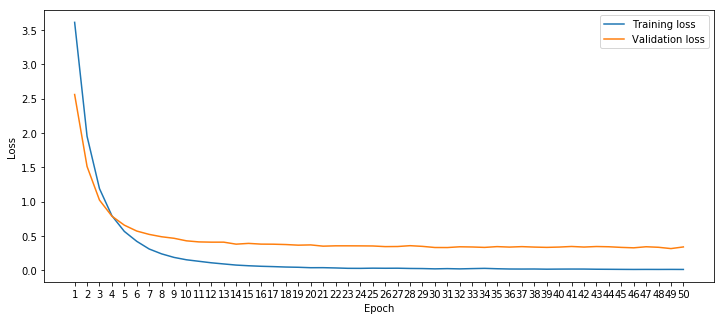

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
epoch_list = np.arange(1, num_epochs+1)
plt.xticks(epoch_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list, train_losses, label="Training loss")
plt.plot(epoch_list, val_losses, label="Validation loss")
plt.legend(loc='upper right')
plt.show()

In [5]:
model.load_state_dict(torch.load('best_model_c_49.pt'))
model.eval()

correct = 0
with torch.no_grad():
    for _, batch in enumerate(test_loader):
        data = batch['image'].to(device)
        labels = batch['label'].long().to(device)
        result = model(data)
        pred = result.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
    
print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), 
                                                       100. * correct / len(test_loader.dataset)))   


Test set: Accuracy: 1503/1639 (92%)

